In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
import spacy
from contractions import fix as expand_contractions
from langdetect import detect
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv("Corona_NLP_train.csv", encoding='ISO-8859-1')

In [12]:
df = df.drop_duplicates(subset="OriginalTweet")

In [13]:
df = df[["OriginalTweet", "Sentiment"]]

In [14]:
def strip_emoji(text):
    """ Remove all emojis from the text using the emoji library's regex. """
    if not isinstance(text, str):
        return text
    return emoji.replace_emoji(text, replace='')

def strip_all_entities(text):
    """ Remove URLs, mentions, non-ASCII characters, punctuations, and normalize text. """
    if not isinstance(text, str):
        return text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.lower().strip()

def clean_hashtags(text):
    """ Remove hashtags at the end of the sentence while retaining those in the middle without the `#` symbol. """
    if not isinstance(text, str):
        return text
    text = re.sub(r'#[\w-]+$', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    return text

def filter_chars(text):
    """ Remove words containing special characters like `$` and `&`. """
    if not isinstance(text, str):
        return text
    return ' '.join([word for word in text.split() if not any(ch in word for ch in ['$', '&'])])

def remove_mult_spaces(text):
    """ Remove multiple spaces from text. """
    if not isinstance(text, str):
        return text
    return re.sub(r'\s{2,}', ' ', text).strip()

def expand_and_normalize(text):
    """ Expand contractions (e.g., "don't" -> "do not") and normalize text. """
    if not isinstance(text, str):
        return text
    text = expand_contractions(text)
    return text

def remove_stopwords(text):
    """ Remove common stopwords from the text using spaCy's built-in stop words. """
    if not isinstance(text, str):
        return text
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

def remove_numbers(text):
    """ Remove all numbers from the text. """
    if not isinstance(text, str):
        return text
    return re.sub(r'\b\d+\b', '', text)

def lemmatize_text(text):
    """ Lemmatize each word in the text to its base form using spaCy. """
    if not isinstance(text, str):
        return text
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text):
    """ Stem each word in the text to its root form using spaCy (using the default stemmer). """
    if not isinstance(text, str):
        return text
    doc = nlp(text)
    return ' '.join([token.text for token in doc])

def clean_text_pipeline(text, use_stemming=False):
    """
    Perform the entire text-cleaning process by combining all cleaning functions.
    Includes optional stemming or lemmatization.
    """
    text = expand_and_normalize(text)
    text = strip_emoji(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_numbers(text)
    text = remove_mult_spaces(text)
    text = remove_stopwords(text)

    if use_stemming:
        text = stem_text(text)
    else:
        text = lemmatize_text(text)

    return text

In [15]:
texts_new = []
for clean_text in df["OriginalTweet"]:
    texts_new.append(clean_text_pipeline(clean_text))

In [16]:
temp_df = pd.Series(' '.join(df['OriginalTweet']).split()).value_counts()
drops = temp_df[temp_df < 2]

df['OriginalTweet'] = df['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [17]:
df["Clean_Text"] = texts_new

In [18]:
texts_lens = []
for lenn in df["Clean_Text"]:
    tweet_len = len(lenn.split())
    texts_lens.append(tweet_len)

In [19]:
df["Text_length"] = texts_lens

In [20]:
df = df[df["Text_length"] > 4]

In [21]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

In [22]:
ls = []
for lang in df["Clean_Text"]:
    ls.append(detect_language(lang))

In [23]:
df["Language_type"] = ls

In [24]:
df = df[df["Language_type"]=="en"]

In [25]:
label_mapping = {'Extremely Positive': 1, 'Positive': 1, 'Neutral': 2,
                 'Negative': 0, 'Extremely Negative': 0}

In [26]:
df["Target"] = df['Sentiment'].map(label_mapping).astype(int)

In [27]:
df = df[(df["Target"]==1) | (df["Target"]==0)]

In [28]:
X = df["Clean_Text"]
y = df["Target"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, stratify=y, random_state=42)

In [30]:
from transformers import RobertaTokenizerFast
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [31]:
MAX_LEN = 128

def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [32]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train.tolist(), MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test.tolist(), MAX_LEN)


In [34]:
def create_model(bert_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    output = bert_model([input_ids, attention_masks])
    output = output[1]

    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model


In [35]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [36]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [37]:
history_2 = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    epochs=4,
    batch_size=30,
    validation_split=0.2
)


Epoch 1/4
858/858 [==============================] - 741s 819ms/step - loss: 0.4242 - binary_accuracy: 0.8013 - val_loss: 0.3235 - val_binary_accuracy: 0.8672
Epoch 2/4
858/858 [==============================] - 704s 821ms/step - loss: 0.3063 - binary_accuracy: 0.8720 - val_loss: 0.3247 - val_binary_accuracy: 0.8685
Epoch 3/4
858/858 [==============================] - 705s 822ms/step - loss: 0.2617 - binary_accuracy: 0.8968 - val_loss: 0.3072 - val_binary_accuracy: 0.8764
Epoch 4/4
858/858 [==============================] - 705s 821ms/step - loss: 0.2225 - binary_accuracy: 0.9158 - val_loss: 0.3212 - val_binary_accuracy: 0.8753


In [38]:
predictions = model.predict([test_input_ids, test_attention_masks])

1/1 [==============================] - 3s 3s/step


In [39]:
predicted_labels = (predictions > 0.5).astype(int).flatten()

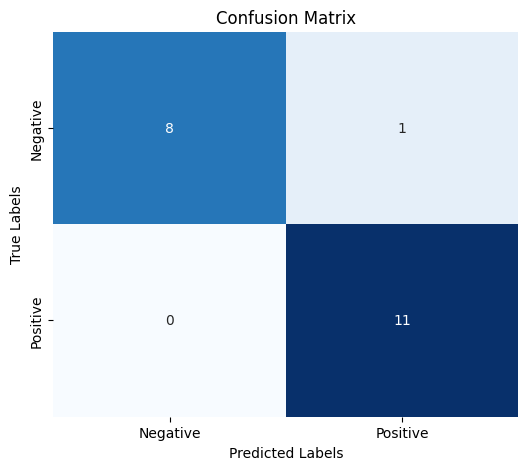

In [45]:
conf_matrix = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [50]:
class_report = classification_report(y_test, predicted_labels, target_names=['Negative', 'Positive'])

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.89      0.94         9
    Positive       0.92      1.00      0.96        11

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



In [61]:
def predict_sentence(model, sentence, max_len=MAX_LEN):
    encoded_input = tokenizer_roberta.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        return_attention_mask=True,
        truncation=True
    )

    input_ids = np.array([encoded_input['input_ids']])
    attention_mask = np.array([encoded_input['attention_mask']])

    prediction = model.predict([input_ids, attention_mask])

    predicted_label = "Positive" if prediction[0][0] > 0.5 else "Negative"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    print(f"Sentence: '{sentence}'")
    print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})")

sample_sentence = "Seeing people gathering in huge crowds like the pandemic’s over is honestly terrifying. Have we learned nothing from the last year?"
sample_sentence = clean_text_pipeline(sample_sentence)
predict_sentence(model, sample_sentence)


1/1 [==============================] - 0s 84ms/step
Sentence: 'see people gather huge crowd like pandemic s honestly terrify learned year'
Predicted Label: Negative (Confidence: 0.51)
